In [114]:
import pandas as pd
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, validation_curve
from sklearn import metrics
from sklearn.metrics import auc, classification_report, f1_score, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

pd.set_option('display.max_columns', 500)

## Data Preprocessing

In [6]:
# Read data
sub = pd.read_pickle(r'subscribers.dms')
sub = sub.set_index('subid')
print(sub.shape)
sub.head()

(227628, 28)


,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,retarget_TF,age,male_TF,country,attribution_technical,attribution_survey,op_sys,months_per_bill_period,plan_type,monthly_price,discount_price,account_creation_date,creation_until_cancel_days,cancel_before_trial_end,trial_end_date,initial_credit_card_declined,revenue_net,join_fee,language,paid_TF,refund_after_trial_TF,payment_type
subid,,,,,,,,,,,,,,,,,,,,,,,,,,,,
21724479,economy,NaN,comedy,access to exclusive content,NaN,NaN,False,NaN,False,UAE,facebook,facebook,Android,4,base_uae_14_day_trial,4.7343,4.5141,2020-01-24 21:44:16,NaN,True,2020-02-08,False,NaN,NaN,ar,True,False,Standard Charter
23383224,base,NaN,comedy,access to exclusive content,22.951579,NaN,False,70.0,False,UAE,facebook,facebook,NaN,4,base_uae_14_day_trial,4.7343,4.5141,2020-03-01 15:44:35,0.0,False,2020-03-16,False,0.0,0.3303,ar,False,False,NaN
26844789,enhanced,3.362885,regional,replace OTT,36.001186,1.951776,False,25.0,True,UAE,organic,facebook,iOS,4,base_uae_14_day_trial,4.7343,4.5141,2019-12-07 16:37:06,1.0,False,2019-12-22,False,0.0,0.1101,ar,False,False,NaN
29417030,base,NaN,drama,replace OTT,20.051667,NaN,False,30.0,False,UAE,search,tv,Android,4,base_uae_14_day_trial,4.7343,4.5141,2020-01-27 16:09:32,0.0,False,2020-02-11,False,0.0,0.0367,ar,False,False,NaN
26723159,base,3.731089,comedy,replace OTT,22.951579,2.506384,False,28.0,False,UAE,discovery,youtube,iOS,4,base_uae_14_day_trial,4.7343,4.5141,2019-10-05 12:57:07,9.0,False,2019-10-20,False,0.0,0.0367,ar,False,False,NaN


In [102]:
# Read engagement data

eng = pd.read_pickle(r'engagement.dms')
print(eng.shape)
eng.head()

(2585724, 9)


,subid,date,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,payment_period
1,22349235,2019-07-01,1.0,1.0,0.0,6.0,0.0,0.0,0.0
2,22349235,2019-07-02,1.0,0.0,0.0,5.0,0.0,0.0,0.0
3,22349235,2019-07-03,0.0,1.0,0.0,0.0,0.0,0.0,0.0
50,20848497,2019-07-02,1.0,0.0,7.0,7.0,0.0,0.0,0.0
51,22680106,2019-07-02,2.0,1.0,7.0,7.0,0.0,1.0,0.0


In [103]:
# We have approximately 1% of null values, which happened when users didn't open the app on that day
eng.isnull().sum()

subid                                  0
date                                   0
app_opens                          34611
cust_service_mssgs                 34611
num_videos_completed               34611
num_videos_more_than_30_seconds    34611
num_videos_rated                   34611
num_series_started                 34611
payment_period                         0
dtype: int64

In [104]:
# Fill the null values with 0
eng = eng.fillna(0)

In [105]:
def period_analysis(df, period):
    
    def active(row):
        if row['app_opens'] != 0:
            return 1
        else:
            return 0
    
    df['duration'] = df.groupby('subid')['date'].transform('count')
    df[ period + 'active'] = df.apply(active,axis=1)
    df[ period + 'active_days'] = df.groupby('subid')[ period + 'active'].transform('count')
    df[ period + 'active_%'] = df[ period + 'active_days']/df['duration']

    # apps_open
    df[ period + 'appopen_count'] = df.groupby('subid')['app_opens'].transform('sum')
    df[ period + 'appopen_avg'] = df.groupby('subid')['app_opens'].transform('mean')

    # cust_service_mssgs
    df[ period + 'msg_count'] = df.groupby('subid')['cust_service_mssgs'].transform('sum')
    df[ period + 'msg_avg'] = df.groupby('subid')['cust_service_mssgs'].transform('mean')

    # num_videos_completed
    df[ period + 'vd_complt_count'] = df.groupby('subid')['num_videos_completed'].transform('sum')
    df[ period + 'vd_complt_avg'] = df.groupby('subid')['num_videos_completed'].transform('mean')

    # num_videos_more_than_30_seconds
    df[ period + 'vd_>30s_count'] = df.groupby('subid')['num_videos_more_than_30_seconds'].transform('sum')
    df[ period + 'vd_>30s_avg'] = df.groupby('subid')['num_videos_more_than_30_seconds'].transform('mean')

    # num_videos_rated
    df[ period + 'vd_rated_count'] = df.groupby('subid')['num_videos_rated'].transform('sum')
    df[ period + 'vd_rated_avg'] = df.groupby('subid')['num_videos_rated'].transform('mean')

    # num_series_started
    df[ period + 'srs_start_count'] = df.groupby('subid')['num_series_started'].transform('sum')
    df[ period + 'srs_start_avg'] = df.groupby('subid')['num_series_started'].transform('mean')

    df = df.drop([ period + 'active'],axis=1)

In [106]:
## First, we want to look at user-wide analysis

eng_id = eng.copy()

period_analysis(eng_id,"")

eng_id['start_date'] = eng_id.groupby('subid')['date'].transform('first')
eng_id['end_date'] = eng_id.groupby('subid')['date'].transform('last')
eng_id['start_month'] = eng_id['start_date'].dt.month_name()
eng_id['end_month'] = eng_id['end_date'].dt.month_name()
eng_id = eng_id.drop(['active','start_date','end_date'],axis=1)

eng_id = eng_id.drop_duplicates('subid').set_index('subid')
eng_id = eng_id.iloc[:,-17:]

In [107]:
## Then, we want to look at product usage in each payment period

# Period = 0
eng_pd_0 = eng.loc[eng['payment_period'] == 0]
period_analysis(eng_pd_0,"p0_")
eng_pd_0 = eng_pd_0.drop_duplicates('subid').set_index('subid')
eng_pd_0 = eng_pd_0.iloc[:,-14:]

# Period = 1
eng_pd_1 = eng.loc[eng['payment_period'] == 1]
period_analysis(eng_pd_1,"p1_")
eng_pd_1 = eng_pd_1.drop_duplicates('subid').set_index('subid')
eng_pd_1 = eng_pd_1.iloc[:,-14:]

# Period = 2
eng_pd_2 = eng.loc[eng['payment_period'] == 2]
period_analysis(eng_pd_2,"p2_")
eng_pd_2 = eng_pd_2.drop_duplicates('subid').set_index('subid')
eng_pd_2 = eng_pd_2.iloc[:,-14:]


# Period = 3
eng_pd_3 = eng.loc[eng['payment_period'] == 3]
period_analysis(eng_pd_3,"p3_")
eng_pd_3 = eng_pd_3.drop_duplicates('subid').set_index('subid')
eng_pd_3 = eng_pd_3.iloc[:,-14:]

In [108]:
# Merge all periods of engagement data

eng_all = pd.merge(eng_id, eng_pd_0, left_index=True, right_index=True, how='left')
eng_all = pd.merge(eng_all, eng_pd_1, left_index=True, right_index=True, how='left')
eng_all = pd.merge(eng_all, eng_pd_2, left_index=True, right_index=True, how='left')
eng_all = pd.merge(eng_all, eng_pd_3, left_index=True, right_index=True, how='left')

In [109]:
eng_all.shape

(135019, 73)

In [110]:
# Read Customer Service Representatives data
rep = pd.read_pickle(r'customer_service_reps.dms')
print(rep.shape)
rep.head()

(2208643, 13)


,customer_service_rep_id,subid,current_sub_TF,cancel_date,account_creation_date,num_trial_days,trial_completed_TF,billing_channel,revenue_net_1month,payment_period,last_payment,next_payment,renew
4,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,0,2019-11-26 03:30:29,2019-11-26 03:30:29,NaN
5,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,1,2019-11-26 03:30:29,2019-12-27 03:30:29,NaN
6,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,2,2019-12-27 03:30:29,2020-01-26 03:30:29,NaN
7,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,3,2020-01-26 03:30:29,NaT,NaN
8,31174901,25914865,True,NaT,2020-03-19 01:20:25,14,True,itunes,1.1377,0,2020-03-19 01:20:25,2020-04-02 01:20:25,NaN


In [111]:
# clean the outliers of variable "age"
def clean_age(data):
    age = data['age']
    if age <= 0 or age >= 100:
        return np.nan
    else:
        return age

# categorize revenue_net to better flag churn
def revenue_cat(data):
    revenue = data['revenue_net']
    if  revenue <= 0:
        return '<=0'
    else:
        return '>0'


## Prepare the data we're going to use for A/B Testing 

# select the UAE plan_type
uae = []
counts = sub.plan_type.value_counts()
for idx in counts.index:
    if 'uae' in idx and '7' not in idx:
        uae.append(idx)

rep = rep.drop_duplicates('subid').set_index('subid').drop('payment_period',axis=1)     
sub_rep = pd.merge(sub, rep, left_index=True, right_index=True, how='inner')
sub_rep_uae = sub_rep[sub_rep['plan_type'].isin(uae)]
sub_rep_uae['age'] = sub_rep_uae.apply(clean_age, axis=1)
sub_rep_uae['revenue_cat'] = sub_rep_uae.apply(revenue_cat, axis=1)
#sub_rep_uae.to_csv('sub_rep_uae.csv')


## Prepare the data we're going to use for Customer Segmentation and Churn Modeling
sub_eng = pd.merge(sub, eng_all, left_index=True, right_index=True, how='inner')
sub_eng_rep = pd.merge(sub_eng, rep, left_index=True, right_index=True, how='inner')
sub_eng_rep['revenue_cat'] = sub_eng_rep.apply(revenue_cat, axis=1)
sub_eng_rep['age'] = sub_eng_rep.apply(clean_age, axis=1)
#sub_eng_rep.to_csv('sub_eng_rep.csv')

## A/B Testing

In [112]:
# Read and prepare data
sub_rep = pd.read_csv('sub_rep_uae.csv')

sub_rep = sub_rep.drop(['package_type','num_weekly_services_utilized','preferred_genre','intended_use',
                        'weekly_consumption_hour','num_ideal_streaming_services','age','male_TF','country',
                        'attribution_technical','attribution_survey','op_sys','months_per_bill_period',
                        'creation_until_cancel_days','initial_credit_card_declined','language','payment_type',
                        'customer_service_rep_id','billing_channel','cancel_before_trial_end'],axis=1)
sub_rep.head()

,subid,retarget_TF,plan_type,monthly_price,discount_price,account_creation_date_x,trial_end_date,revenue_net,join_fee,paid_TF,refund_after_trial_TF,current_sub_TF,cancel_date,account_creation_date_y,num_trial_days,trial_completed_TF,revenue_net_1month,payment_period,last_payment,next_payment,renew,revenue_cat
0,20000062,False,base_uae_14_day_trial,4.7343,4.5141,2019-06-30 22:44:55,2019-07-15 00:00:00,0.00,0.0367,False,False,False,2019-07-04 17:44:28,2019-06-30 22:44:55,14,False,0.0000,0,2019-06-30 23:05:47,NaN,False,<=0
1,20000405,False,base_uae_14_day_trial,4.7343,4.5141,2020-03-08 11:25:48,2020-03-23 00:00:00,0.00,0.6606,False,False,False,2020-03-18 00:48:31,2020-03-08 11:25:48,14,False,0.0000,0,2020-03-08 14:14:06,NaN,False,<=0
2,20000604,False,base_uae_14_day_trial,4.7343,4.5141,2020-02-09 13:26:49,2020-02-24 00:00:00,NaN,NaN,True,False,True,NaN,2020-02-09 13:26:49,14,True,4.5875,0,2020-02-09 14:05:27,2020-02-24 11:05:23,True,>0
3,20000604,False,base_uae_14_day_trial,4.7343,4.5141,2020-02-09 13:26:49,2020-02-24 00:00:00,NaN,NaN,True,False,True,NaN,2020-02-09 13:26:49,14,True,4.5875,1,2020-02-24 11:05:23,NaN,False,>0
4,20000685,True,base_uae_14_day_trial,4.7343,4.5141,2020-03-03 05:55:37,2020-03-18 00:00:00,3.67,0.3303,True,False,True,NaN,2020-03-03 05:55:37,14,True,3.6700,0,2020-03-03 07:43:33,2020-03-18 14:33:41,True,>0


In [113]:
print(sub_rep.shape)

(209846, 22)


### 14-day Trial VS No Trial
For 14-day Trial users: Converted if Trial Completed and Revenue > 0
<br>For No Trial users: Converted if Revenue > 0 (or paid_TF=True)

In [114]:
sub_rep.groupby(['trial_completed_TF','refund_after_trial_TF','revenue_cat']).size()

trial_completed_TF  refund_after_trial_TF  revenue_cat
False               False                  <=0             72657
True                False                  <=0              5534
                                           >0             122997
                    True                   <=0              6265
                                           >0               2393
dtype: int64

In [115]:
# Define the conversions of No Trial users
sub_rep_0_trial = sub_rep.loc[sub_rep['num_trial_days']==0]

def convert_trial_0(data):
    revenue = data['revenue_cat']
    if  revenue == '>0':
        return 1
    else:
        return 0

sub_rep_0_trial['conversion'] = sub_rep_0_trial.apply(convert_trial_0,axis=1)

# Define the conversions of 14-day Trial users
sub_rep_14_trial = sub_rep.loc[(sub_rep['num_trial_days']==14) & (sub_rep['plan_type']=='base_uae_14_day_trial')
                              & (sub_rep['retarget_TF']==True)]

def convert_trial_14(data):
    revenue = data['revenue_cat']
    trial = data['trial_completed_TF']
    if  revenue == '>0' and trial == True:
        return 1
    else:
        return 0

sub_rep_14_trial['conversion'] = sub_rep_14_trial.apply(convert_trial_14,axis=1)

### Hypotheses
A: 14-day Trial
<br>B: No Trial
<br>H0: Conversion Rate A = B
<br>H1: Conversion Rate A != B

In [116]:
### Conduct A/B Testing
sub_rep_trial_AB = pd.concat([sub_rep_0_trial,sub_rep_14_trial])
sub_rep_trial_AB = sub_rep_trial_AB[['subid','num_trial_days','conversion']].reset_index()

# number of samples
n_A = sub_rep_trial_AB.query('num_trial_days=="14"').shape[0]
n_B = sub_rep_trial_AB.query('num_trial_days=="0"').shape[0]
print("Number of samples for A: {} and B: {}".format(n_A,n_B))

# number of conversions
conver_A = sub_rep_trial_AB.query('num_trial_days=="14" & conversion=="1"').shape[0]
conver_B = sub_rep_trial_AB.query('num_trial_days=="0" & conversion=="1"').shape[0]
print("Number of conversions for A: {} and B: {}".format(conver_A,conver_B))

# conversion rate
p_A = round(conver_A/n_A,2)
p_B = round(conver_B/n_B,2)
print("Conversion rate for A: {} and B: {}".format(p_A,p_B))

from scipy import stats as st
from scipy.stats import norm
z_alpha = st.norm.ppf(1-0.05/2)
z = (p_B-p_A) / np.sqrt(p_A*(1-p_A)/n_B)
print("Z_alpha: {} and Z:{}".format(z_alpha,z))

z > z_alpha

Number of samples for A: 7034 and B: 88
Number of conversions for A: 4479 and B: 81
Conversion rate for A: 0.64 and B: 0.92
Z_alpha: 1.959963984540054 and Z:5.4721517197940015


True

In [117]:
# Calculate the optimal size
from scipy.stats import norm
z_beta = st.norm.ppf(1-0.2)

p_hat = (p_A+p_B)/2

n = (z_alpha*np.sqrt(2*p_hat*(1-p_hat))+z_beta*np.sqrt(p_A*(1-p_A)+p_B*(1-p_B)))**2 * 1/(p_B-p_A)**2 
print("Optimal sample size is %.2f" % n)

Optimal sample size is 33.15


In [118]:
# Conduct the test 10 times

def ab_test(N_concat): 
    test=[]

    n_A = N_concat.query('num_trial_days=="14"').shape[0]
    n_B = N_concat.query('num_trial_days=="0"').shape[0]
    
    convert_N_A = N_concat.query('num_trial_days=="14" & conversion=="1"').shape[0]
    convert_N_B = N_concat.query('num_trial_days=="0" & conversion=="1"').shape[0]
    
    p_N_A = round(convert_N_A / n_A,2)
    p_N_B = round(convert_N_B / n_B,2)
    
    z_alpha = st.norm.ppf(1-0.05/2)
    z = round((p_N_B-p_N_A) / np.sqrt(p_N_A*(1-p_N_A)/n_B),2)
    
    reject_H0 = z > z_alpha 
    
    test.append(p_N_B)
    test.append(z)
    test.append(reject_H0)
    
    return test

ab_dict={}

i=0
while i < 10:
    N_A = sub_rep_trial_AB[sub_rep_trial_AB["num_trial_days"]==14]
    N_B = sub_rep_trial_AB[sub_rep_trial_AB["num_trial_days"]==0].sample(n=33)
    N_concat = pd.concat([N_A,N_B])
    ab_dict[i]=ab_test(N_concat)
    i += 1

df = pd.DataFrame(ab_dict)
df = df.T
df.rename(columns={0:'p_B_sample', 1:'z_score', 2:'reject_H0'},inplace=True)
df = df.T
trials=[1,2,3,4,5,6,7,8,9,10]
df.columns = trials
df

,1,2,3,4,5,6,7,8,9,10
p_B_sample,0.91,0.88,0.91,0.94,0.91,0.85,0.97,0.94,0.94,0.97
z_score,3.23,2.87,3.23,3.59,3.23,2.51,3.95,3.59,3.59,3.95
reject_H0,True,True,True,True,True,True,True,True,True,True


10/10 trials we can reject H0: For retargeted customers, conversion rate of 14-day Trial = conversion rate of No Trial and accept that No Trial affects the converision rate.

### Base 14-day Trial VS High 14-day Trial
For both 14-day Trial users: Converted if Trial Completed and Revenue > 0

In [119]:
sub_rep_base= sub_rep.loc[(sub_rep['plan_type']=='base_uae_14_day_trial') & (sub_rep['retarget_TF']==False)]
sub_rep_high = sub_rep.loc[(sub_rep['plan_type']=='high_uae_14_day_trial') & (sub_rep['retarget_TF']==False)]

sub_rep_base['conversion'] = sub_rep_base.apply(convert_trial_14,axis=1)
sub_rep_high['conversion'] = sub_rep_high.apply(convert_trial_14,axis=1)

### Hypotheses
A: Base 14-day Trial
<br>B: High 14-day Trial
<br>H0: Conversion Rate A = B
<br>H1: Conversion Rate A != B

In [120]:
### Conduct A/B Testing
sub_rep_trial_AB_2 = pd.concat([sub_rep_base,sub_rep_high])
sub_rep_trial_AB_2 = sub_rep_trial_AB_2[['subid','plan_type','conversion']].reset_index()

# number of samples
n_A = sub_rep_trial_AB_2.query('plan_type=="base_uae_14_day_trial"').shape[0]
n_B = sub_rep_trial_AB_2.query('plan_type=="high_uae_14_day_trial"').shape[0]
print("Number of samples for A: {} and B: {}".format(n_A,n_B))

# number of conversions
conver_A = sub_rep_trial_AB_2.query('plan_type=="base_uae_14_day_trial" & conversion=="1"').shape[0]
conver_B = sub_rep_trial_AB_2.query('plan_type=="high_uae_14_day_trial" & conversion=="1"').shape[0]
print("Number of conversions for A: {} and B: {}".format(conver_A,conver_B))

# conversion rate
p_A = round(conver_A/n_A,2)
p_B = round(conver_B/n_B,2)
print("Conversion rate for A: {} and B: {}".format(p_A,p_B))

from scipy import stats as st
from scipy.stats import norm
z_alpha = st.norm.ppf(1-0.05/2)
z = (p_B-p_A) / np.sqrt(p_A*(1-p_A)/n_B)
print("Z_alpha: {} and Z:{}".format(z_alpha,z))

z > z_alpha

Number of samples for A: 202349 and B: 373
Number of conversions for A: 120616 and B: 214
Conversion rate for A: 0.6 and B: 0.57
Z_alpha: 1.959963984540054 and Z:-1.1826876172514882


False

In [121]:
# Calculate the optimal size
from scipy.stats import norm
z_beta = st.norm.ppf(1-0.2)

p_hat = (p_A+p_B)/2

n = (z_alpha*np.sqrt(2*p_hat*(1-p_hat))+z_beta*np.sqrt(p_A*(1-p_A)+p_B*(1-p_B)))**2 * 1/(p_B-p_A)**2 
print("Optimal sample size is %.2f" % n)

Optimal sample size is 4233.29


We failed to reject H0: Conversion rate of Base 14-day Trial = Conversion rate of High 14-day Trial. High 14-day Trial can not affect the conversion rate.

## Customer Segmentation

In [122]:
# Read and prepare data

sub_eng_rep = pd.read_csv('sub_eng_rep.csv', index_col=0).reset_index()
sub_eng_rep = sub_eng_rep.drop(['monthly_price','account_creation_date_x','creation_until_cancel_days','cancel_before_trial_end',
                                'trial_end_date','initial_credit_card_declined','revenue_net','duration','attribution_survey',
                                'customer_service_rep_id','cancel_date','revenue_net_1month','last_payment',
                               'country','language','billing_channel','months_per_bill_period','account_creation_date_y'], axis=1)
for col in sub_eng_rep.columns:
    if 'avg' in col:
        sub_eng_rep = sub_eng_rep.drop(col,axis=1)

sub_eng_rep.head()

,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,retarget_TF,age,male_TF,attribution_technical,op_sys,plan_type,discount_price,join_fee,paid_TF,refund_after_trial_TF,payment_type,active_days,active_%,appopen_count,msg_count,vd_complt_count,vd_>30s_count,vd_rated_count,srs_start_count,start_month,end_month,p0_active_days,p0_active_%,p0_appopen_count,p0_msg_count,p0_vd_complt_count,p0_vd_>30s_count,p0_vd_rated_count,p0_srs_start_count,p1_active_days,p1_active_%,p1_appopen_count,p1_msg_count,p1_vd_complt_count,p1_vd_>30s_count,p1_vd_rated_count,p1_srs_start_count,p2_active_days,p2_active_%,p2_appopen_count,p2_msg_count,p2_vd_complt_count,p2_vd_>30s_count,p2_vd_rated_count,p2_srs_start_count,p3_active_days,p3_active_%,p3_appopen_count,p3_msg_count,p3_vd_complt_count,p3_vd_>30s_count,p3_vd_rated_count,p3_srs_start_count,current_sub_TF,num_trial_days,trial_completed_TF,next_payment,renew,revenue_cat
0,26844789,enhanced,3.362885,regional,replace OTT,36.001186,1.951776,False,25.0,True,organic,iOS,base_uae_14_day_trial,4.5141,0.1101,False,False,NaN,2,1.0,2.0,2.0,13.0,13.0,0.0,1.0,December,December,2.0,1.0,2.0,2.0,13.0,13.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,14,False,NaN,False,<=0
1,29726122,base,2.049135,comedy,access to exclusive content,20.051667,1.860289,False,61.0,False,bing,Android,base_uae_14_day_trial,4.5141,0.3303,True,False,Standard Charter,41,1.0,40.0,17.0,182.0,182.0,6.0,39.0,February,April,10.0,1.0,9.0,9.0,46.0,46.0,0.0,8.0,31.0,1.0,31.0,8.0,136.0,136.0,6.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,14,True,2020-03-05 13:52:53,True,>0
2,20299962,base,3.002048,drama,access to exclusive content,34.551230,1.870503,False,23.0,False,email,iOS,base_uae_14_day_trial,4.5141,0.0000,True,False,RAKBANK,46,1.0,104.0,10.0,84.0,206.0,0.0,29.0,March,April,15.0,1.0,51.0,4.0,66.0,74.0,0.0,14.0,31.0,1.0,53.0,6.0,18.0,132.0,0.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,14,True,2020-03-20 13:54:48,True,>0
3,24930568,base,NaN,comedy,access to exclusive content,25.851492,NaN,False,73.0,False,facebook,iOS,base_uae_14_day_trial,4.5141,0.6606,False,False,NaN,2,1.0,3.0,3.0,2.0,13.0,0.0,0.0,February,February,2.0,1.0,3.0,3.0,2.0,13.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,14,False,NaN,False,<=0
4,21361112,enhanced,NaN,comedy,access to exclusive content,37.451142,NaN,False,24.0,True,search,iOS,base_uae_14_day_trial,4.5141,0.3303,False,False,NaN,2,1.0,4.0,3.0,2.0,12.0,0.0,0.0,December,December,2.0,1.0,4.0,3.0,2.0,12.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,14,False,NaN,False,<=0


In [123]:
# Drop columns with lots of null values and replace them with 0
thresh = pd.Series(sub_eng_rep.isnull().sum())
thresh = thresh[thresh > 10000]
null_index_list = thresh.index
sub_eng_rep = sub_eng_rep.drop(null_index_list, axis=1)

sub_eng_rep.fillna(0, inplace=True)

In [124]:
# Get dummies of categorical values
sub_eng_rep_clus = pd.get_dummies(sub_eng_rep, columns=['plan_type','intended_use','attribution_technical',
                                                        'op_sys','start_month','end_month',
                                                          'revenue_cat'])
sub_eng_rep_clus = sub_eng_rep_clus.drop('subid',axis=1)
print(sub_eng_rep_clus.shape)
sub_eng_rep_clus.head()

(135019, 101)


,retarget_TF,male_TF,discount_price,paid_TF,refund_after_trial_TF,active_days,active_%,appopen_count,msg_count,vd_complt_count,vd_>30s_count,vd_rated_count,srs_start_count,p0_active_days,p0_active_%,p0_appopen_count,p0_msg_count,p0_vd_complt_count,p0_vd_>30s_count,p0_vd_rated_count,p0_srs_start_count,current_sub_TF,num_trial_days,trial_completed_TF,renew,plan_type_base_eur_14_day_trial,plan_type_base_uae_14_day_trial,plan_type_base_uae_no_trial_7_day_guarantee,plan_type_high_aud_14_day_trial,plan_type_high_jpy_14_day_trial,plan_type_high_sar_14_day_trial,plan_type_high_uae_14_day_trial,plan_type_low_gbp_14_day_trial,plan_type_low_uae_no_trial,intended_use_0,intended_use_access to exclusive content,intended_use_education,intended_use_expand international access,intended_use_expand regional access,intended_use_other,intended_use_replace OTT,intended_use_supplement OTT,attribution_technical_affiliate,attribution_technical_appstore,attribution_technical_bing,attribution_technical_bing_organic,attribution_technical_brand sem intent bing,attribution_technical_brand sem intent google,attribution_technical_content_greatist,attribution_technical_criteo,attribution_technical_direct_mail,attribution_technical_discovery,attribution_technical_display,attribution_technical_email,attribution_technical_email_blast,attribution_technical_facebook,attribution_technical_facebook_organic,attribution_technical_google_organic,attribution_technical_influencer,attribution_technical_internal,attribution_technical_organic,attribution_technical_other,attribution_technical_ott,attribution_technical_pinterest,attribution_technical_pinterest_organic,attribution_technical_playstore,attribution_technical_podcast,attribution_technical_quora,attribution_technical_referral,attribution_technical_samsung,attribution_technical_search,attribution_technical_tv,attribution_technical_twitter,attribution_technical_vod,attribution_technical_youtube,op_sys_0,op_sys_Android,op_sys_iOS,start_month_August,start_month_December,start_month_February,start_month_January,start_month_July,start_month_June,start_month_March,start_month_November,start_month_October,start_month_September,end_month_April,end_month_August,end_month_December,end_month_February,end_month_January,end_month_July,end_month_June,end_month_March,end_month_November,end_month_October,end_month_September,revenue_cat_<=0,revenue_cat_>0
0,False,True,4.5141,False,False,2,1.0,2.0,2.0,13.0,13.0,0.0,1.0,2.0,1.0,2.0,2.0,13.0,13.0,0.0,1.0,False,14,False,False,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,False,False,4.5141,True,False,41,1.0,40.0,17.0,182.0,182.0,6.0,39.0,10.0,1.0,9.0,9.0,46.0,46.0,0.0,8.0,True,14,True,True,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,False,False,4.5141,True,False,46,1.0,104.0,10.0,84.0,206.0,0.0,29.0,15.0,1.0,51.0,4.0,66.0,74.0,0.0,14.0,True,14,True,True,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,False,False,4.5141,False,False,2,1.0,3.0,3.0,2.0,13.0,0.0,0.0,2.0,1.0,3.0,3.0,2.0,13.0,0.0,0.0,False,14,False,False,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,False,True,4.5141,False,False,2,1.0,4.0,3.0,2.0,12.0,0.0,0.0,2.0,1.0,4.0,3.0,2.0,12.0,0.0,0.0,False,14,False,False,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


### Elbow Test

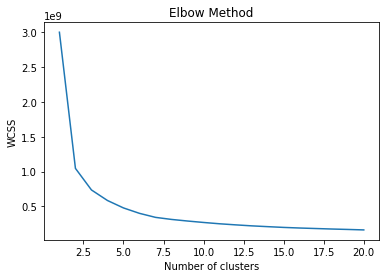

In [125]:
from sklearn.cluster import KMeans

def get_wcss(df):
  wcss = []
  for i in range(1, 21):
      kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
      kmeans.fit(df)
      wcss.append(kmeans.inertia_)
  plt.plot(range(1, 21), wcss)
  plt.title('Elbow Method')
  plt.xlabel('Number of clusters')
  plt.ylabel('WCSS')
  plt.show()

# determine k - look at wcss for each number of clustrs to determine how number of clusters
get_wcss(sub_eng_rep_clus)

### Predict Clusters

In [126]:
# Create k-means model
nclusters = 3

kmeans = KMeans(n_clusters=nclusters, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(sub_eng_rep_clus)
cluster = kmeans.fit_predict(sub_eng_rep_clus)

In [127]:
# Let's look at the centroids of each feature for each cluster
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = sub_eng_rep_clus.columns

# Drop the features which have too little difference among clusters
for col in centroids.columns:
    if (centroids[col].diff()[1] < 0.1) and (centroids[col].diff()[2] < 0.1):
        centroids = centroids.drop(col,axis=1)
        
centroids
#centroids.to_csv('/Users/huangyurong/Desktop/Marketing Analytics/Final Case/cluster_summary.csv', index=False, header=True)

,paid_TF,active_days,appopen_count,msg_count,vd_complt_count,vd_>30s_count,vd_rated_count,srs_start_count,p0_active_days,p0_appopen_count,p0_msg_count,p0_vd_complt_count,p0_vd_>30s_count,p0_vd_rated_count,p0_srs_start_count,current_sub_TF,trial_completed_TF,renew,op_sys_Android,op_sys_iOS,end_month_April,revenue_cat_>0
0,0.215597,7.617946,12.205384,3.800103,16.347712,33.703517,0.011856,3.271035,6.433882,10.874163,3.526888,15.952686,29.913749,0.003945,3.053887,0.106637,0.264564,0.215333,0.333665,0.666285,0.028257,0.182949
1,0.999178,66.037277,241.226330,23.316287,231.256726,279.642842,6.805299,56.233313,14.955946,67.279934,8.823167,68.290203,75.631649,0.208256,13.605360,0.703019,0.999178,0.999178,0.132265,0.867735,0.109776,0.997433
2,0.992917,44.652576,81.756755,14.698445,122.385010,193.512423,3.103616,32.980476,14.693236,31.640210,7.354132,58.222372,72.541465,0.163125,12.267416,0.561926,0.995278,0.992580,0.331834,0.668166,0.219899,0.985760


In [128]:
# Mark each customer with the cluster he/she is assigned to

cluster_result = pd.DataFrame({'subid': sub_eng_rep.subid.values})

cluster_result['cluster'] = np.where(cluster==0, "Medium Addicted",
                                             np.where(cluster==1, "Inactive and Churn",
                                                      "Heavily Addicted"))
cluster_result.head()

,subid,cluster
0,26844789,Medium Addicted
1,29726122,Heavily Addicted
2,20299962,Heavily Addicted
3,24930568,Medium Addicted
4,21361112,Medium Addicted


## Churn Forecasting

In [117]:
sub_eng_rep = pd.read_csv('sub_eng_rep.csv', index_col=0).reset_index()
sub_eng_rep = sub_eng_rep.drop(['monthly_price','account_creation_date_x','creation_until_cancel_days','cancel_before_trial_end',
                                'trial_end_date','initial_credit_card_declined','duration','attribution_survey','next_payment',
                                'customer_service_rep_id','cancel_date','revenue_net','revenue_net_1month','last_payment',
                               'country','language','billing_channel','months_per_bill_period','account_creation_date_y'], axis=1)

### Predict Whether Trial Users Will Become Full Subscribers
Churn if failed to complete the trial
<br> Churn if completed trial, requested refund, and revenue <= 0
<br> Churn if completed trial, revenue <= 0 though did not request refund

In [118]:
sub_eng_rep_1 = sub_eng_rep.copy()
sub_eng_rep_1.groupby(['trial_completed_TF','refund_after_trial_TF','revenue_cat']).size()

trial_completed_TF  refund_after_trial_TF  revenue_cat
False               False                  <=0            72645
True                False                  <=0             5195
                                           >0             52871
                    True                   <=0             3123
                                           >0              1185
dtype: int64

In [119]:
def churn_1(data):
    trial = data['trial_completed_TF']
    refund = data['refund_after_trial_TF']
    revenue = data['revenue_cat']
    
    if trial == False:
        return 1
    elif (trial == True) & (refund == True) & (revenue != '>0'):
        return 1
    elif (trial == True) & (refund == False) & (revenue != '>0'):
        return 1
    else: 
        return 0

sub_eng_rep_1['churn'] = sub_eng_rep_1.apply(churn_1, axis=1)

In [120]:
sub_eng_rep_1.churn.value_counts()

1    80963
0    54056
Name: churn, dtype: int64

In [121]:
# Drop columns which involved in the determination of churn 
sub_eng_rep_1 = sub_eng_rep_1.drop(['revenue_cat','paid_TF','trial_completed_TF','refund_after_trial_TF',], axis=1)

# Drop columns with lots of null values and replace them with 0
thresh = pd.Series(sub_eng_rep_1.isnull().sum())
thresh = thresh[thresh > 10000]
null_index_list = thresh.index
sub_eng_rep_1 = sub_eng_rep_1.drop(null_index_list, axis=1)
sub_eng_rep_1 = sub_eng_rep_1.drop('renew', axis=1)

print(sub_eng_rep_1.shape)
sub_eng_rep_1.head()

(135019, 41)


,subid,intended_use,retarget_TF,male_TF,attribution_technical,op_sys,plan_type,discount_price,active_days,active_%,appopen_count,appopen_avg,msg_count,msg_avg,vd_complt_count,vd_complt_avg,vd_>30s_count,vd_>30s_avg,vd_rated_count,vd_rated_avg,srs_start_count,srs_start_avg,start_month,end_month,p0_active_days,p0_active_%,p0_appopen_count,p0_appopen_avg,p0_msg_count,p0_msg_avg,p0_vd_complt_count,p0_vd_complt_avg,p0_vd_>30s_count,p0_vd_>30s_avg,p0_vd_rated_count,p0_vd_rated_avg,p0_srs_start_count,p0_srs_start_avg,current_sub_TF,num_trial_days,churn
0,26844789,replace OTT,False,True,organic,iOS,base_uae_14_day_trial,4.5141,2,1.0,2.0,1.00000,2.0,1.000000,13.0,6.500000,13.0,6.500000,0.0,0.000000,1.0,0.500000,December,December,2.0,1.0,2.0,1.0,2.0,1.000000,13.0,6.5,13.0,6.500000,0.0,0.0,1.0,0.500000,False,14,1
1,29726122,access to exclusive content,False,False,bing,Android,base_uae_14_day_trial,4.5141,41,1.0,40.0,0.97561,17.0,0.414634,182.0,4.439024,182.0,4.439024,6.0,0.146341,39.0,0.951220,February,April,10.0,1.0,9.0,0.9,9.0,0.900000,46.0,4.6,46.0,4.600000,0.0,0.0,8.0,0.800000,True,14,0
2,20299962,access to exclusive content,False,False,email,iOS,base_uae_14_day_trial,4.5141,46,1.0,104.0,2.26087,10.0,0.217391,84.0,1.826087,206.0,4.478261,0.0,0.000000,29.0,0.630435,March,April,15.0,1.0,51.0,3.4,4.0,0.266667,66.0,4.4,74.0,4.933333,0.0,0.0,14.0,0.933333,True,14,0
3,24930568,access to exclusive content,False,False,facebook,iOS,base_uae_14_day_trial,4.5141,2,1.0,3.0,1.50000,3.0,1.500000,2.0,1.000000,13.0,6.500000,0.0,0.000000,0.0,0.000000,February,February,2.0,1.0,3.0,1.5,3.0,1.500000,2.0,1.0,13.0,6.500000,0.0,0.0,0.0,0.000000,False,14,1
4,21361112,access to exclusive content,False,True,search,iOS,base_uae_14_day_trial,4.5141,2,1.0,4.0,2.00000,3.0,1.500000,2.0,1.000000,12.0,6.000000,0.0,0.000000,0.0,0.000000,December,December,2.0,1.0,4.0,2.0,3.0,1.500000,2.0,1.0,12.0,6.000000,0.0,0.0,0.0,0.000000,False,14,1


In [122]:
# Fill categorical null values with "other"
def intend_use(data):
    use = data['intended_use']
    if pd.isna(use) == True:
        use = 'other'
    return use
sub_eng_rep_1['intended_use'] = sub_eng_rep_1.apply(intend_use, axis=1)

def op_sys(data):
    sys = data['op_sys']
    if pd.isna(sys) == True:
        sys = 'other'
    return sys
sub_eng_rep_1['op_sys'] = sub_eng_rep_1.apply(op_sys, axis=1)

# Fill continuos null values with 0
sub_eng_rep_1.fillna(0, inplace=True)

In [123]:
# Get dummies of categorical values
sub_eng_rep_1 = pd.get_dummies(sub_eng_rep_1, columns=['intended_use','attribution_technical','op_sys','plan_type',
                                                      'start_month','end_month'])
print(sub_eng_rep_1.shape)
sub_eng_rep_1.head()

(135019, 108)


,subid,retarget_TF,male_TF,discount_price,active_days,active_%,appopen_count,appopen_avg,msg_count,msg_avg,vd_complt_count,vd_complt_avg,vd_>30s_count,vd_>30s_avg,vd_rated_count,vd_rated_avg,srs_start_count,srs_start_avg,p0_active_days,p0_active_%,p0_appopen_count,p0_appopen_avg,p0_msg_count,p0_msg_avg,p0_vd_complt_count,p0_vd_complt_avg,p0_vd_>30s_count,p0_vd_>30s_avg,p0_vd_rated_count,p0_vd_rated_avg,p0_srs_start_count,p0_srs_start_avg,current_sub_TF,num_trial_days,churn,intended_use_access to exclusive content,intended_use_education,intended_use_expand international access,intended_use_expand regional access,intended_use_other,intended_use_replace OTT,intended_use_supplement OTT,attribution_technical_affiliate,attribution_technical_appstore,attribution_technical_bing,attribution_technical_bing_organic,attribution_technical_brand sem intent bing,attribution_technical_brand sem intent google,attribution_technical_content_greatist,attribution_technical_criteo,attribution_technical_direct_mail,attribution_technical_discovery,attribution_technical_display,attribution_technical_email,attribution_technical_email_blast,attribution_technical_facebook,attribution_technical_facebook_organic,attribution_technical_google_organic,attribution_technical_influencer,attribution_technical_internal,attribution_technical_organic,attribution_technical_other,attribution_technical_ott,attribution_technical_pinterest,attribution_technical_pinterest_organic,attribution_technical_playstore,attribution_technical_podcast,attribution_technical_quora,attribution_technical_referral,attribution_technical_samsung,attribution_technical_search,attribution_technical_tv,attribution_technical_twitter,attribution_technical_vod,attribution_technical_youtube,op_sys_Android,op_sys_iOS,op_sys_other,plan_type_base_eur_14_day_trial,plan_type_base_uae_14_day_trial,plan_type_base_uae_no_trial_7_day_guarantee,plan_type_high_aud_14_day_trial,plan_type_high_jpy_14_day_trial,plan_type_high_sar_14_day_trial,plan_type_high_uae_14_day_trial,plan_type_low_gbp_14_day_trial,plan_type_low_uae_no_trial,start_month_August,start_month_December,start_month_February,start_month_January,start_month_July,start_month_June,start_month_March,start_month_November,start_month_October,start_month_September,end_month_April,end_month_August,end_month_December,end_month_February,end_month_January,end_month_July,end_month_June,end_month_March,end_month_November,end_month_October,end_month_September
0,26844789,False,True,4.5141,2,1.0,2.0,1.00000,2.0,1.000000,13.0,6.500000,13.0,6.500000,0.0,0.000000,1.0,0.500000,2.0,1.0,2.0,1.0,2.0,1.000000,13.0,6.5,13.0,6.500000,0.0,0.0,1.0,0.500000,False,14,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,29726122,False,False,4.5141,41,1.0,40.0,0.97561,17.0,0.414634,182.0,4.439024,182.0,4.439024,6.0,0.146341,39.0,0.951220,10.0,1.0,9.0,0.9,9.0,0.900000,46.0,4.6,46.0,4.600000,0.0,0.0,8.0,0.800000,True,14,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,20299962,False,False,4.5141,46,1.0,104.0,2.26087,10.0,0.217391,84.0,1.826087,206.0,4.478261,0.0,0.000000,29.0,0.630435,15.0,1.0,51.0,3.4,4.0,0.266667,66.0,4.4,74.0,4.933333,0.0,0.0,14.0,0.933333,True,14,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,24930568,False,False,4.5141,2,1.0,3.0,1.50000,3.0,1.500000,2.0,1.000000,13.0,6.500000,0.0,0.000000,0.0,0.000000,2.0,1.0,3.0,1.5,3.0,1.500000,2.0,1.0,13.0,6.500000,0.0,0.0,0.0,0.000000,False,14,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,21361112,False,True,4.5141,2,1.0,4.0,2.00000,3.0,1.500000,2.0,1.000000,12.0,6.000000,0.0,0.000000,0.0,0.000000,2.0,1.0,4.0,2.0,3.0,1.500

In [124]:
def model_evaluation(clf):
    clf.fit(X_train, y_train)
    #print("Coefficient of each independent variable is {}".format(clf.coef_))
    print("Mean train cross-validation score (5-folds): {:.4f}".format(np.mean(cross_val_score(clf, X_train, y_train, cv=5))))
    print("Mean test cross-validation score (5-folds): {:.4f}".format(np.mean(cross_val_score(clf, X_test, y_test, cv=5))))

    pred = clf.predict(X_test)
    prob = clf.predict_proba(X_test)[:,1]
    #print('Training accuracy: {:.4f}'.format(clf.score(X_train, y_train)))
    #print('Test accuracy: {:.4f}'.format(clf.score(X_test, y_test)))
    print('AUC: {:.4f}'.format(metrics.roc_auc_score(y_test,prob)))

    CM = confusion_matrix(y_test,pred)
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    recall = tp/(tp+fn) 
    precision = tp/(tp+fp) 
    #print("Confusion matrix for the test set: {}".format(CM))
    #print("TN: {} / FP: {} / FN: {} / TP: {}".format(tn, fp, fn, tp))
    print("Recall: {:.4f} / Precision: {:.4f}".format(recall, precision))
    #print(classification_report(y_test, pred))

In [125]:
X = sub_eng_rep_1.drop(['churn'],axis=1)
y = sub_eng_rep_1['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Logistic Regression

In [126]:
from sklearn.linear_model import LogisticRegression

for c in [.01,.1,1,10,100]:
    clf = LogisticRegression(C=c)
    model_evaluation(clf)
    print("-"*60)

Mean train cross-validation score (5-folds): 0.8713
Mean test cross-validation score (5-folds): 0.8072
AUC: 0.9519
Recall: 0.9807 / Precision: 0.8906
------------------------------------------------------------
Mean train cross-validation score (5-folds): 0.8713
Mean test cross-validation score (5-folds): 0.8072
AUC: 0.9519
Recall: 0.9807 / Precision: 0.8906
------------------------------------------------------------
Mean train cross-validation score (5-folds): 0.8713
Mean test cross-validation score (5-folds): 0.8072
AUC: 0.9519
Recall: 0.9807 / Precision: 0.8906
------------------------------------------------------------
Mean train cross-validation score (5-folds): 0.8713
Mean test cross-validation score (5-folds): 0.8072
AUC: 0.9519
Recall: 0.9807 / Precision: 0.8906
------------------------------------------------------------
Mean train cross-validation score (5-folds): 0.8713
Mean test cross-validation score (5-folds): 0.8072
AUC: 0.9519
Recall: 0.9807 / Precision: 0.8906
------

In [127]:
clf_best = LogisticRegression(C=1).fit(X_train, y_train)

cols = X_train.columns

# Calculate the correlation coefficient between each feature and the target feature
index = 0
for i in clf_best.coef_[0]:
    print("%s      %.5f" %(cols[index],i))
    index += 1

subid      0.00000
retarget_TF      0.00001
male_TF      -0.00036
discount_price      0.00101
active_days      -0.04398
active_%      0.00022
appopen_count      -0.01888
appopen_avg      0.00533
msg_count      0.00280
msg_avg      0.00214
vd_complt_count      0.02258
vd_complt_avg      0.01071
vd_>30s_count      -0.12110
vd_>30s_avg      0.00660
vd_rated_count      -0.00191
vd_rated_avg      -0.00004
srs_start_count      -0.00610
srs_start_avg      0.00164
p0_active_days      0.00625
p0_active_%      0.00023
p0_appopen_count      0.05009
p0_appopen_avg      0.00493
p0_msg_count      0.01328
p0_msg_avg      0.00176
p0_vd_complt_count      0.07024
p0_vd_complt_avg      0.00734
p0_vd_>30s_count      0.05263
p0_vd_>30s_avg      0.00435
p0_vd_rated_count      -0.00007
p0_vd_rated_avg      -0.00001
p0_srs_start_count      0.01241
p0_srs_start_avg      0.00131
current_sub_TF      -0.00366
num_trial_days      0.00316
intended_use_access to exclusive content      -0.00002
intended_use_education

### Decision Tree

In [128]:
from sklearn.tree import DecisionTreeClassifier

# Set parameters to help avoid overfitting
for dep in [3,4,5,6,7]:
        clfDT = DecisionTreeClassifier(max_depth=dep, max_features='sqrt', min_samples_leaf=50).fit(X_train, y_train)
        print("The result for Decision Tree Model with depth={}: ".format(dep))
        model_evaluation(clfDT)
        print("-"*60)

The result for Decision Tree Model with depth=3: 
Mean train cross-validation score (5-folds): 0.8261
Mean test cross-validation score (5-folds): 0.8969
AUC: 0.8666
Recall: 0.9019 / Precision: 0.8598
------------------------------------------------------------
The result for Decision Tree Model with depth=4: 
Mean train cross-validation score (5-folds): 0.9031
Mean test cross-validation score (5-folds): 0.8687
AUC: 0.9122
Recall: 0.9870 / Precision: 0.8480
------------------------------------------------------------
The result for Decision Tree Model with depth=5: 
Mean train cross-validation score (5-folds): 0.9161
Mean test cross-validation score (5-folds): 0.9141
AUC: 0.9237
Recall: 0.9809 / Precision: 0.8861
------------------------------------------------------------
The result for Decision Tree Model with depth=6: 
Mean train cross-validation score (5-folds): 0.9269
Mean test cross-validation score (5-folds): 0.9155
AUC: 0.9417
Recall: 0.9823 / Precision: 0.8836
-----------------

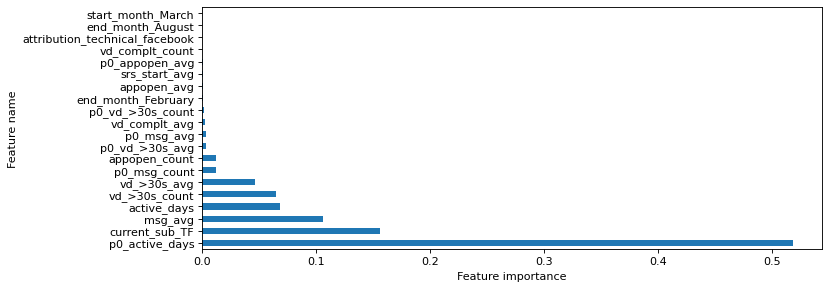

In [129]:
# Decision Tree Model with the best params
clf_DT_best = DecisionTreeClassifier(max_depth=7, max_features='sqrt', min_samples_leaf=50, random_state=0).fit(X_train, y_train)

def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    feat_importances = pd.Series(clf_DT_best.feature_importances_, index=feature_names)
    feat_importances.nlargest(20).plot(kind='barh')
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    
plt.figure(figsize=(10,4), dpi=80)
plot_feature_importances(clf_DT_best, X_train.columns)
plt.show()

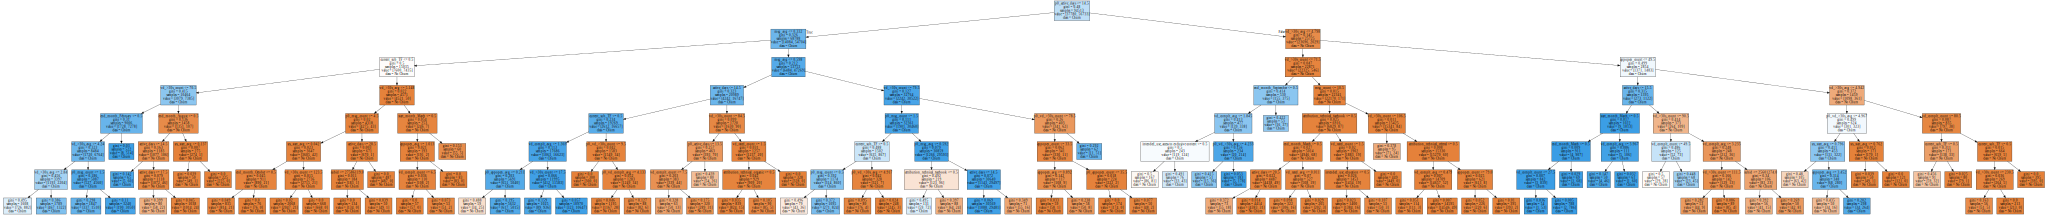

In [130]:
# Plot the decision tree 
from sklearn import tree
from IPython.display import SVG, display, Image
from graphviz import Source

graph = Source(tree.export_graphviz(clf_DT_best, out_file=None
   , feature_names=X.columns, class_names=['No Churn', 'Churn'] 
   , filled = True))
display(SVG(graph.pipe(format='svg')))

## Revenue Modeling

In [131]:
# Create dataframe which ids were labelled with predict probabilities
churn = pd.DataFrame(data=clf_DT_best.predict_proba(X_test))
churn = churn.join(pd.DataFrame(y_test).reset_index())
churn = churn.merge(pd.DataFrame(sub_eng_rep_1['subid']).reset_index(),on='index')
churn = churn[['subid','churn',1]]
churn.columns = ['subid','y_test','y_pred']
churn

,subid,y_test,y_pred
0,28987069,0,0.752511
1,23458101,0,0.007023
2,25912585,0,0.003357
3,23202018,0,0.003357
4,23821831,1,0.964408
...,...,...,...
40501,21146820,1,0.890447
40502,26239438,1,0.964408
40503,27410966,0,0.007023
40504,27028541,0,0.003357


In [132]:
offer_accept_rate = 0.3

def receive(y_pred,thresh):
    if y_pred >= thresh:
        return 1
    else:
        return 0

import random
def accept(receive):
    if receive == 1:
        if random.random() <= offer_accept_rate:
            return 1
        else:
            return 0
    else:
        return 0
    
def renew(row,thresh):
    value = 0
    receive = 'receive_offer_'+str(thresh)
    accept = 'accept_offer_'+str(thresh)
    if (row.y_test == 0):
        if (row[receive] == 0) | ((row[receive] == 1) & (row[accept] == 0)):
            value = 1
    return value

def plan(row,thresh):
    accept = 'accept_offer_'+str(thresh)
    renew = 'renew_at_base_'+str(thresh)
    if row[accept] == 1:
        return 'offer'
    elif row[renew] == 1:
        return 'base'
    else:
        return 'churn'

In [133]:
# Create dataframe for revenue modeling
def rev_model(churn, offer_accept_rate, thresh):
    
    rec = 'receive_offer_'+str(thresh)
    churn[rec] = churn.apply(lambda x: receive(x['y_pred'],thresh),axis=1)
    
    acc = 'accept_offer_'+str(thresh)
    churn[acc] = churn[rec].apply(accept)
    
    ren = 'renew_at_base_'+str(thresh)
    churn[ren] = churn.apply(lambda x: renew(x,thresh),axis=1)
    
    pl = 'plan_'+str(thresh)
    churn[pl] = churn.apply(lambda x: plan(x,thresh),axis=1)
    
    return churn

In [134]:
rev_model(churn,offer_accept_rate,0.5)

,subid,y_test,y_pred,receive_offer_0.5,accept_offer_0.5,renew_at_base_0.5,plan_0.5
0,28987069,0,0.752511,1,0,1,base
1,23458101,0,0.007023,0,0,1,base
2,25912585,0,0.003357,0,0,1,base
3,23202018,0,0.003357,0,0,1,base
4,23821831,1,0.964408,1,1,0,offer
...,...,...,...,...,...,...,...
40501,21146820,1,0.890447,1,1,0,offer
40502,26239438,1,0.964408,1,0,0,churn
40503,27410966,0,0.007023,0,0,1,base
40504,27028541,0,0.003357,0,0,1,base


## Calculating Customer CLV

In [135]:
# Read data
spend = pd.read_excel('advertising_spend_data.xlsx',header=2)
spend['month'] = spend['date'].dt.month_name()
spend = spend.set_index(['month']).drop('date',axis=1)
spend

,facebook,email,search,brand sem intent google,affiliate,email_blast,pinterest,referral
month,,,,,,,,
June,84800,75000,17300,21400,11900,10500,5900,6100
July,60000,75600,17300,21300,12000,29800,6000,6600
August,52300,76100,18100,21300,16300,65900,6200,6800
September,49000,75800,18900,21300,16400,73700,6000,7400
October,51300,76000,21000,21400,12200,32300,6700,7300
November,56100,75900,21400,21600,11700,9800,6300,7300
December,51400,76100,32100,22200,12100,3500,7200,8000
January,49000,75500,33600,22700,14300,300,6700,7400
February,49700,76600,30100,21700,15000,300,6400,6500


In [136]:
# Adjust the spend to the percentage of data we have on subscriber data
rep_2 = pd.read_pickle(r'customer_service_reps.dms')
rep_2['month'] = rep_2['account_creation_date'].dt.month_name()
rep_2 = rep_2.drop_duplicates('subid')

sub = pd.read_pickle(r'subscribers.dms')
sub['month'] = sub['account_creation_date'].dt.month_name()

adjust = rep_2.groupby('month').size().to_frame('rep_count')
adjust['sub_count'] = sub.groupby('month').size()
adjust['pct'] = adjust['sub_count']/adjust['rep_count']

spend['pct'] = [0.127728,0.116322,0.234436,0.184377,0.193055,0.138201,0.188798,0.257344,0.158847,0.136252]

for col in spend.columns:
    if 'pct' not in col:
        spend[col] = spend[col] * spend['pct']

spend = spend.drop('pct',axis=1)
spend

,facebook,email,search,brand sem intent google,affiliate,email_blast,pinterest,referral
month,,,,,,,,
June,10831.3344,9579.6000,2209.6944,2733.3792,1519.9632,1341.1440,753.5952,779.1408
July,6979.3200,8793.9432,2012.3706,2477.6586,1395.8640,3466.3956,697.9320,767.7252
August,12261.0028,17840.5796,4243.2916,4993.4868,3821.3068,15449.3324,1453.5032,1594.1648
September,9034.4730,13975.7766,3484.7253,3927.2301,3023.7828,13588.5849,1106.2620,1364.3898
October,9903.7215,14672.1800,4054.1550,4131.3770,2355.2710,6235.6765,1293.4685,1409.3015
November,7753.0761,10489.4559,2957.5014,2985.1416,1616.9517,1354.3698,870.6663,1008.8673
December,9704.2172,14367.5278,6060.4158,4191.3156,2284.4558,660.7930,1359.3456,1510.3840
January,12609.8560,19429.4720,8646.7584,5841.7088,3680.0192,77.2032,1724.2048,1904.3456
February,7894.6959,12167.6802,4781.2947,3446.9799,2382.7050,47.6541,1016.6208,1032.5055


In [137]:
# Filter to subscribers who were acquired from these channels
sub_channel = sub[sub['attribution_technical'].isin(spend.columns.tolist())]
sub_channel['month'] = sub_channel['account_creation_date'].dt.month_name()
sub_channel = sub_channel[(sub_channel['cancel_before_trial_end'] == True)&(sub_channel['refund_after_trial_TF'] == False)]
sub_channel.head()

,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,retarget_TF,age,male_TF,country,attribution_technical,attribution_survey,op_sys,months_per_bill_period,plan_type,monthly_price,discount_price,account_creation_date,creation_until_cancel_days,cancel_before_trial_end,trial_end_date,initial_credit_card_declined,revenue_net,join_fee,language,paid_TF,refund_after_trial_TF,payment_type,month
162502,21724479,economy,NaN,comedy,access to exclusive content,NaN,NaN,False,NaN,False,UAE,facebook,facebook,Android,4,base_uae_14_day_trial,4.7343,4.5141,2020-01-24 21:44:16,NaN,True,2020-02-08,False,NaN,NaN,ar,True,False,Standard Charter,January
315863,20299962,base,3.002048,drama,access to exclusive content,34.551230,1.870503,False,23.0,False,UAE,email,referral,iOS,4,base_uae_14_day_trial,4.7343,4.5141,2020-03-05 14:52:22,NaN,True,2020-03-20,False,3.4498,0.0000,ar,True,False,RAKBANK,March
143042,26874196,base,NaN,comedy,access to exclusive content,NaN,NaN,False,NaN,False,UAE,facebook,facebook,iOS,4,base_uae_14_day_trial,4.7343,4.5141,2020-03-09 03:09:57,NaN,True,2020-03-24,False,NaN,NaN,ar,True,False,Paypal,March
216541,25575254,economy,NaN,comedy,access to exclusive content,NaN,NaN,False,NaN,False,UAE,facebook,facebook,Android,4,base_uae_14_day_trial,4.7343,4.5141,2020-02-08 05:49:40,NaN,True,2020-02-23,False,NaN,NaN,ar,True,False,Standard Charter,February
435503,21908764,base,NaN,drama,access to exclusive content,25.851492,NaN,False,29.0,False,UAE,facebook,facebook,Android,4,base_uae_14_day_trial,4.7343,4.5141,2020-01-10 00:12:01,16.0,True,2020-01-25,True,0.0000,0.0367,ar,False,False,NaN,January


In [138]:
# Calculate CAC for each customer by month by channel
sub_cac = sub_channel.groupby(['month','attribution_technical']).size().to_frame(name='count')
sub_cac = sub_cac.reset_index()

spend_list=[]

for index, row in sub_cac.iterrows():
    month = row['month']
    channel = row['attribution_technical']
    for index, row in spend.iterrows():
        if index == month:
            spend_list.append(row[channel])

sub_cac['spend'] = spend_list
sub_cac['CAC'] = sub_cac['spend'] / sub_cac['count']
sub_cac

,month,attribution_technical,count,spend,CAC
0,August,affiliate,911,3821.3068,4.194629
1,August,brand sem intent google,886,4993.4868,5.635990
2,August,email,1385,17840.5796,12.881285
3,August,email_blast,937,15449.3324,16.488082
4,August,facebook,3713,12261.0028,3.302182
...,...,...,...,...,...
75,September,email_blast,820,13588.5849,16.571445
76,September,facebook,2301,9034.4730,3.926325
77,September,pinterest,192,1106.2620,5.761781
78,September,referral,327,1364.3898,4.172446


In [145]:
sub_clv = sub[['subid','monthly_price','discount_price','join_fee','month','attribution_technical']]
churn_2 = churn[['subid','y_test','y_pred']]
sub_clv = pd.merge(sub_clv, churn_2, on='subid')
sub_clv

,subid,monthly_price,discount_price,join_fee,month,attribution_technical,y_test,y_pred
0,26844789,4.7343,4.5141,0.1101,December,organic,1,0.964408
1,24930568,4.7343,4.5141,0.6606,February,facebook,1,0.964408
2,23163827,4.7343,4.5141,0.0367,August,facebook,1,0.970556
3,21760199,4.7343,4.5141,0.0000,July,email,1,0.964408
4,28863903,4.7343,4.5141,0.3303,March,facebook,1,0.970556
...,...,...,...,...,...,...,...,...
40501,24317364,4.7343,4.5141,0.0367,August,facebook,1,0.964408
40502,22218943,4.7343,4.5141,0.0367,November,brand sem intent bing,1,0.964408
40503,21928274,4.7343,4.5141,NaN,January,facebook,0,0.000000
40504,25549852,4.7343,4.5141,0.3303,March,affiliate,1,0.964408


In [146]:
merge_clv = pd.merge(sub_clv, sub_cac, on=['month','attribution_technical'],how='left')
merge_clv = merge_clv.drop(['count','spend'],axis=1)
merge_clv

,subid,monthly_price,discount_price,join_fee,month,attribution_technical,y_test,y_pred,CAC
0,26844789,4.7343,4.5141,0.1101,December,organic,1,0.964408,NaN
1,24930568,4.7343,4.5141,0.6606,February,facebook,1,0.964408,2.712954
2,23163827,4.7343,4.5141,0.0367,August,facebook,1,0.970556,3.302182
3,21760199,4.7343,4.5141,0.0000,July,email,1,0.964408,5.781685
4,28863903,4.7343,4.5141,0.3303,March,facebook,1,0.970556,2.570101
...,...,...,...,...,...,...,...,...,...
40501,24317364,4.7343,4.5141,0.0367,August,facebook,1,0.964408,3.302182
40502,22218943,4.7343,4.5141,0.0367,November,brand sem intent bing,1,0.964408,NaN
40503,21928274,4.7343,4.5141,NaN,January,facebook,0,0.000000,5.550113
40504,25549852,4.7343,4.5141,0.3303,March,affiliate,1,0.964408,3.193123


In [147]:
# Fill CAC for organic channels with 0
organic_list = ['organic','google_organic','bing_organic','pininterest_organic','facebook_organic']

def organic(row):
    if row['attribution_technical'] in organic_list:
        return 0
    else:
        return row['CAC']
    
merge_clv['CAC'] = merge_clv.apply(organic,axis=1)

# Fill mean for other null values
merge_clv['CAC'].fillna(sub_cac.CAC.mean(),inplace=True)

In [148]:
# Distribution table of expected CLV

discount_rate = 0.03 # assumme annual discount rate = 0.1, so for 4 months is 0.03

def clv(row):
    clv = (row['discount_price']*4) * ((1 + discount_rate)/((1 + discount_rate) - (1 - row['y_pred']))) 
    clv = clv + (row['discount_price'] * 4) + row['join_fee'] - row['CAC']
    return clv

merge_clv['CLV'] = merge_clv.apply(clv,axis=1)
merge_clv

,subid,monthly_price,discount_price,join_fee,month,attribution_technical,y_test,y_pred,CAC,CLV
0,26844789,4.7343,4.5141,0.1101,December,organic,1,0.964408,0.000000,36.869170
1,24930568,4.7343,4.5141,0.6606,February,facebook,1,0.964408,2.712954,34.706716
2,23163827,4.7343,4.5141,0.0367,August,facebook,1,0.970556,3.302182,33.378674
3,21760199,4.7343,4.5141,0.0000,July,email,1,0.964408,5.781685,30.977385
4,28863903,4.7343,4.5141,0.3303,March,facebook,1,0.970556,2.570101,34.404355
...,...,...,...,...,...,...,...,...,...,...
40501,24317364,4.7343,4.5141,0.0367,August,facebook,1,0.964408,3.302182,33.493588
40502,22218943,4.7343,4.5141,0.0367,November,brand sem intent bing,1,0.964408,9.133983,27.661787
40503,21928274,4.7343,4.5141,NaN,January,facebook,0,0.000000,5.550113,NaN
40504,25549852,4.7343,4.5141,0.3303,March,affiliate,1,0.964408,3.193123,33.896247
